In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from CASutils import regrid_utils as regrid
from CASutils import mapplot_utils as mymaps
from CASutils import colorbar_utils as cbars
from CASutils import averaging_utils as avg
from CASutils import linfit_utils as linfit

from math import nan
from functools import partial

In [2]:
plotpath="/project/cas/islas/python_plots/singleforcing_paper/figures/supplemental/"

In [3]:
piboots = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/fig11/CESM2_FSUSregontoMOC.nc")

In [4]:
lens2amoc = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2/LENS2_AMOC45_am.nc").MOC
lens2fsus = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2/LENS2_fsus_integral_am.nc").FSUS

### Remove the ensemble mean

In [5]:
lens2amoc_em = lens2amoc.mean('M')
lens2fsus_em = lens2fsus.mean('M')

In [6]:
lens2amoc = lens2amoc - lens2amoc_em
lens2fsus = lens2fsus - lens2fsus_em

### Calculate 21 year running means

In [7]:
lens2amoc_sm = lens2amoc.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
lens2fsus_sm = lens2fsus.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')

### Lagged regression centered on years from 1890 to 2090

In [8]:
yearplot=[1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2020,2030,2040,2050]
lag = np.arange(-40,41)
regfsus = np.zeros([len(yearplot),len(lag)])

for iyear in np.arange(0,len(yearplot),1):
    amocbase = lens2amoc_sm.sel(year=yearplot[iyear])
    for ilag in np.arange(0,len(lag),1):
        fsususe = lens2fsus_sm.sel(year=yearplot[iyear]+lag[ilag])
        a, b = linfit.linfit_xy(amocbase, fsususe)
        regfsus[iyear, ilag] = b

In [9]:
### Set up color bar for lines
from matplotlib.colors import ListedColormap ## used to create custom colormaps
import matplotlib.colors as mcolors

def makecolormap(n):
    nblues=8
    nreds=n-nblues
    
    colors1 = plt.cm.Blues_r(np.linspace(0,1, int(nblues)))
    colors2 = plt.cm.YlOrRd(np.linspace(0,0.6, int(nreds)))
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap',colors)
    
    return mymap, colors

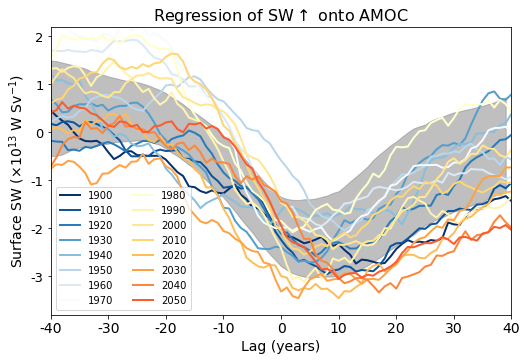

In [10]:
fig = plt.figure(figsize=(16,16))

yearmap, yearcolors = makecolormap(len(yearplot))

ax = fig.add_axes([0.05,0.7,0.4,0.25])

ax.set_xlim(-40,40)
ax.set_ylim(-3.8e13,2.2e13)
ax.set_xticks([-40,-30,-20,-10,0,10,20,30,40])
ax.set_xticklabels(['-40','-30','-20','-10','0','10','20','30','40'], fontsize=14)
ax.set_yticks([-3e13,-2e13,-1e13, 0, 1e13,2e13])
ax.set_yticklabels(['-3','-2','-1','0','1','2'], fontsize=13)
ax.set_ylabel('Surface SW ($\\times$10$^{13}$ W Sv$^{-1}$)', fontsize=14)
ax.set_xlabel('Lag (years)', fontsize=14)
ax.set_title('Regression of SW$\\uparrow$ onto AMOC', fontsize=16)

ax.fill_between(piboots.lag, piboots.min95_fsusreg, piboots.max95_fsusreg, color='gray', alpha=0.5)

for iyear in np.arange(0,len(yearplot),1):
    ax.plot(lag, regfsus[iyear,:], color=yearcolors[iyear], linewidth=2, label=yearplot[iyear])
    
ax.legend(ncol=2)

fig.savefig(plotpath+'figS9.png', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'figS9.pdf', bbox_inches='tight', facecolor='white')